<a href="https://colab.research.google.com/github/diogosaucedo/Praticas-de-IA/blob/main/Previs%C3%A3o_Carne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL

Esta parte é responsável pelo processo de extração, transformação e carregamento dos dados. 
Todas as informações foram coletadas do CEPEA - USP e podem ser auditadas a qualquer momento.
https://cepea.esalq.usp.br/br

**Bibliotecas**
> **pandas**: O pandas é uma ferramenta de análise e manipulação de dados.
**functools**: O módulo functools é para funções de ordem superior: funções que atuam ou retornam a outras funções. Em geral, qualquer objeto que pode ser chamado pode ser tratado como uma função para os fins deste módulo.
**tablib**: A ferramenta dispõe de mais de 200 indicadores técnicos para análise financeira. Amplamente utilizada por desenvolvedores de softwares de negociação que exigem a análise técnica de dados do mercado financeiro.

In [ ]:
import pandas as pd
from functools import reduce
from talib.abstract import *

## Dados

`arroba_boi` recebe um csv contendo o preço da arroba do boi historicamente. Sendo que uma arroba corresponde a 15kg.
`algodão` recebe um csv contendo o preço da pluma de algodão, este valor está em centavos por libra-peso.
`frango` recebe um arquivo onde contém o preço histórico do kg do frango.
`suino` recebe dados contendo informações sobre o preço histórico do kg da carne de porco.
`milho` armazena os dados do preço histórico da saca de 60kg de milho.
`soja` armazena os dados do preço histórico da saca de 60kg de soja.


In [ ]:
arroba_boi = pd.read_csv('CEPEA_ARROBA_BOI.csv', decimal=",")
algodao = pd.read_csv('CEPEA_ALGODAO.CSV', decimal=",")
frango = pd.read_csv('CEPEA_KG_FRANGO.csv', decimal=",")
suino = pd.read_csv('CEPEA_KG_SUINO.csv', decimal=",")
milho = pd.read_csv('CEPEA_SACA_MILHO.csv', decimal=",")
soja = pd.read_csv('CEPEA_SACA_SOJA.csv', decimal=",")

Os dados coletados possuem intervalos de tempos diferentes, alguns começaram a ser coletados em 1996 e outros em 2013, a frequência de coleta também não é igual para todos os itens, sendo alguns atualizados diariamente e outros não. Para ter todos os campos com dados reais escolhemos um intervalo de tempo entre 03-01-2013 e 26-04-2021.

In [ ]:
# Gerando datas entre 03-01-2013 e 26-04-2021.
dias = pd.DataFrame(pd.date_range(start='2013-01-03', end='2021-04-26', freq='D').strftime('%d/%m/%Y'),
                    columns=['Data'])
dfs = [dias, arroba_boi, algodao, frango, suino, milho, soja]
# Juntando todos os dataframes com merge left pelo campo 'Data', pois queremos manter somente os dados com das datas 
# listadas em 'dias'
dataframe = reduce(lambda left, right: pd.merge(left, right, on=['Data'], how='left'), dfs)
# Renomeando colunas
dataframe.columns = ['data', 'preco_arroba_real', 'preco_arroba_dolar', 'preco_algodao_real', 'preco_algodao_dolar',
                     'preco_frango_real', 'preco_frango_dolar', 'preco_suino', 'preco_milho_real', 'preco_milho_dolar',
                     'preco_soja_real', 'preco_soja_dolar']
# calculando cotação do dolar
dataframe['dolar'] = dataframe['preco_arroba_real'] / dataframe['preco_arroba_dolar']
# Excluindo colunas que não iremos ultilizar
dataframe = dataframe.drop(columns=['data', 'preco_algodao_dolar', 'preco_frango_dolar', 'preco_milho_dolar',
                                    'preco_soja_dolar', 'preco_arroba_dolar'])
# Excluindo todas as LINHAS que possuirem TODOS os campos de coluna com valores 'NaN'
dataframe = dataframe.dropna(axis=0, how='all')
print(dataframe)

      preco_arroba_real  preco_algodao_real  preco_frango_real  preco_suino  \
0                 97.73              159.42               3.98         5.73   
1                 97.91              161.73               4.01         5.60   
4                 97.88              163.90               4.01         5.53   
5                 97.02              165.76               4.04         5.70   
6                 97.58              167.25               3.96         5.80   
...                 ...                 ...                ...          ...   
3028             315.40              489.48               6.09        11.36   
3029             315.85              494.45               6.23        11.87   
3031             316.65              498.93               6.23        11.87   
3032                NaN              506.91               6.23        11.89   
3035                NaN              512.06               6.23        11.90   

      preco_milho_real  preco_soja_real     dolar  

## Indicadores

## RSI
O Índice de Força Relativa (RSI) é um oscilador baseado em impulso bem versado que é usado para medir a velocidade, bem como a mudança (magnitude) dos movimentos de preços direcionais. Essencialmente, o RSI, quando apresentado em gráfico, fornece um meio visual de monitorar as notícias, bem como o histórico, pontos fortes e fracos de um determinado mercado. A força ou fraqueza é baseada nos preços de fechamento durante um período de negociação especificado, criando uma métrica confiável para mudanças de preço e momentum.

## EMA 
A média móvel exponencial (EMA) é um indicador gráfico técnico que rastreia o preço de um investimento (como uma ação ou commodity) ao longo do tempo. A EMA é um tipo de média móvel ponderada (WMA) que dá mais peso ou importância aos dados de preços recentes. Como a média móvel simples, a média móvel exponencial é usada para ver as tendências de preços ao longo do tempo.

## Timeperiod
Este atributo é responsável por determinar quantas amostras o indicador utilizará para fazer os cálculos. Quanto mais próximo a 1, mais flexível tende a ser o indicador, sendo que a k-ésima amostra e o k-ésimo valor calculado pelo indicador terão valores próximos, tornando-o pouco sensível à variação de preço. O mesmo se aplica a ordem inversa, valores positivos distantes de 1 tendem a tornar o indicador mais sensível a variação de preços, pois o  k-ésimo valor do indicador não acompanha facilmente a k-ésima amostra.

In [ ]:
# Calculando EMA de 100 periodos
dataframe['ema_arroba_real'] = EMA(dataframe['preco_arroba_real'], timeperiod=100)
# Calculando RSI de 14 periodos
dataframe['rsi_arroba_real'] = RSI(dataframe['preco_arroba_real'], timeperiod=14)
dataframe['ema_dolar'] = EMA(dataframe['dolar'], timeperiod=100)
dataframe['ema_algodao'] = EMA(dataframe['preco_algodao_real'], timeperiod=100)
dataframe['ema_frango'] = EMA(dataframe['preco_frango_real'], timeperiod=100)
dataframe['ema_suino'] = EMA(dataframe['preco_suino'], timeperiod=100)
dataframe['ema_milho'] = EMA(dataframe['preco_milho_real'], timeperiod=100)
dataframe['ema_soja'] = EMA(dataframe['preco_soja_real'], timeperiod=100)
dataframe.fillna(method="ffill", inplace=True)  # ffill: propaga a última observação válida para a próxima válida
dataframe.fillna(method="bfill", inplace=True)  # bfill: usa a próxima observação válida para preencher a lacuna.

## Classes
As classes prevista neste modelo serão valores de 0 e 1, sendo **baixa** e **alta** de preços respectivamentes. O horizonte de previsão será de 10 dias.

In [ ]:
temp_arroba = dataframe['preco_arroba_real'].shift(-10)  # desloca o dataframe 10 posições
temp_arroba.fillna(method="ffill", inplace=True)
temp_arroba.fillna(method="bfill", inplace=True)
temp_arroba, copy_iterable = list(temp_arroba), list(dataframe['preco_arroba_real'])
classes = [1 if temp_arroba[i] > copy_iterable[i] else 0 for i in range(len(copy_iterable))]  # 1 = alta, 0 = baixa

## Correlação
Calcula a correlação de pares de colunas, excluindo NaN / valores nulos.

**Bibliotecas:** `seaborn` é uma biblioteca de visualização de dados Python baseada em matplotlib. `pytplot` é um módulo do Matplotlib que oferece uma interface semelhante ao MATLAB.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Gerando mapa de calor com dados de correlação das colunas retornados da função `dataframe.corr()`.

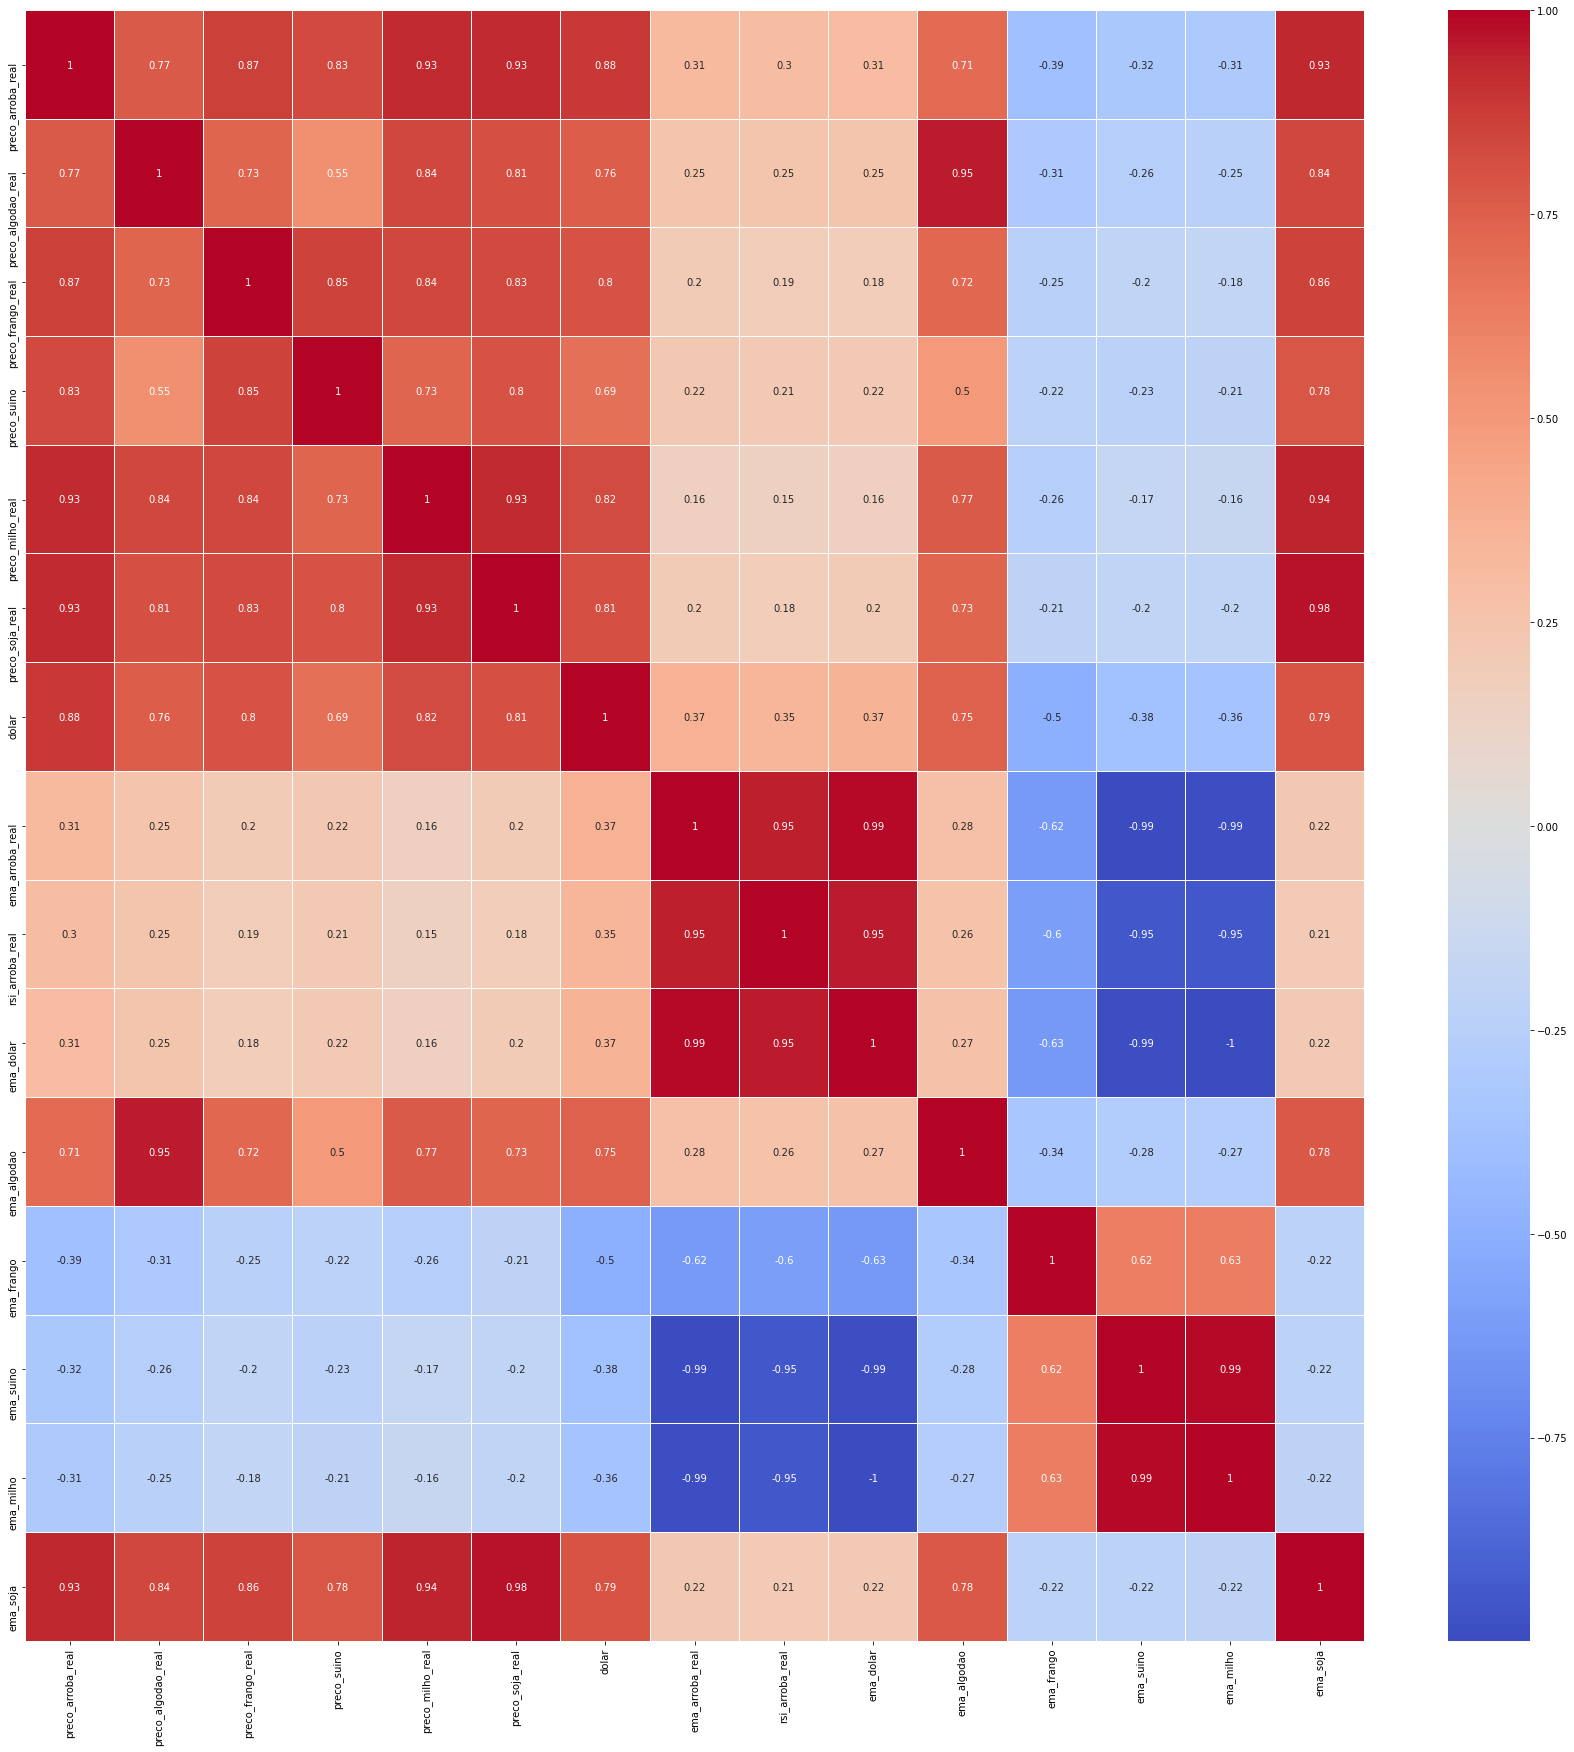

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(dataframe.corr(), annot=True, linewidths=0.01, cmap='coolwarm', cbar=True)
plt.show()

Observando o campo `preço_arroba_real` podemos notar que os únicos campos que não influenciam diretamente no preço são: "ema_frango","ema_suino","ema_milho". Estes campos serão removidos.

In [ ]:
# Excluindo colunas que não iremos ultilizar
dataframe = dataframe.drop(columns=['ema_frango', 'ema_suino', 'ema_milho'])

`pairplot` nos permite observar a relação entre pares de dados. O parâmetro `hue` faz um mapeamento semântico e nos mostra uma estimativa de densidade do kernel em camadas. Neste exemplo o `hue` mapeia o campo "classes" mostrando sua distribuição de densidade, cores 'transparentes' significam baixa densidade, enquanto as cores fortes representam alta densidade.

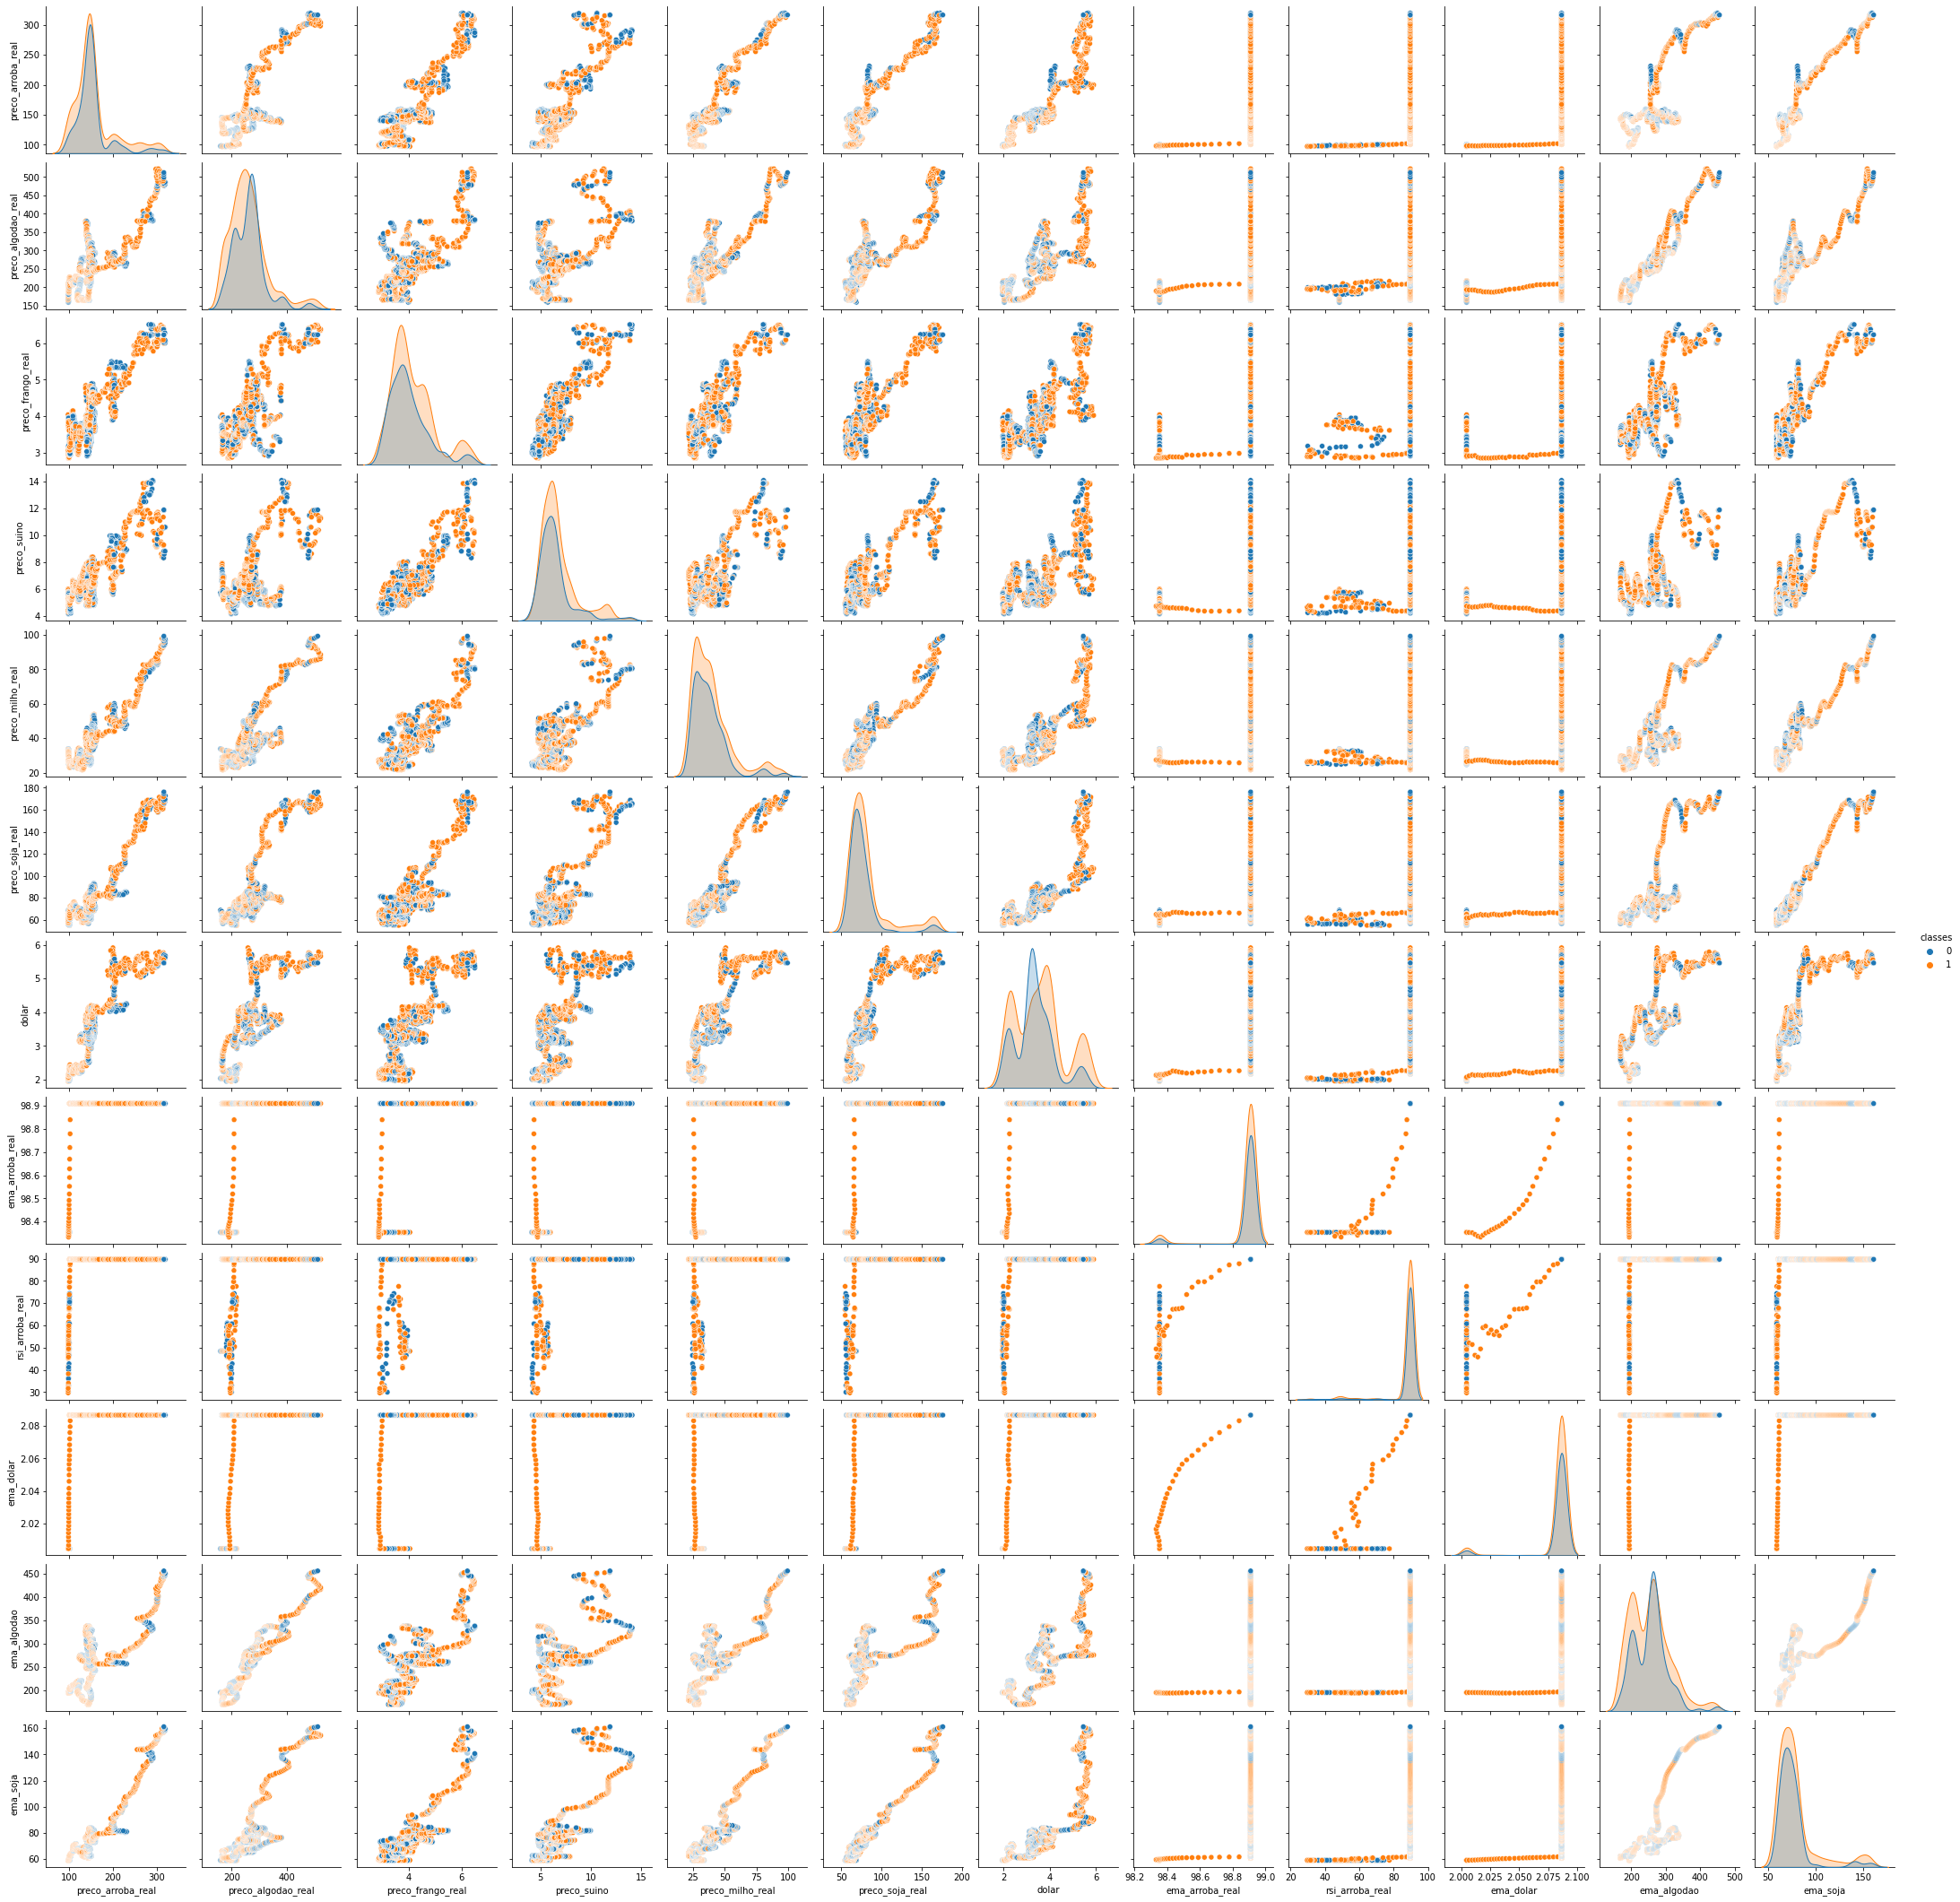

In [ ]:
dataframe['classes'] = classes
sns.pairplot(data=dataframe, hue='classes')
dataframe = dataframe.drop(columns=['classes'])

Podemos observar que boa parte dos dados, com exceção das EMAs e RSIs, tendem a formar figuras que se assemelham a uma reta, mostrando forte relação entre si. Por exemplo, se olharmos para o preço do algodão, soja e milho, podemos notar que seus aumentos refletem fortemente no preço da arroba do boi, fazendo com que o mesmo valorize.

# Divisão e Transformação

`train_test_split` possibilita a divisão de um dataframe em uma porcentagem definida pelo parâmetro `test_size`, neste caso 0.2 = 20%, que corresponde a quantidade de amostras que será usada para fazer o teste/predição. Aqui usaremos os dados de forma embaralhada ao invés de temporal, isso é definido pelo parâmetro `random_state`. `QuantileTransformer` é responsável por fazer o mapeamento de distribuição de uma variável e realizar a transformação para outro padrão de distribuição, que pode ser **Gaussiano** ou **Uniforme**, neste exemplo usaremos o default que é **Uniforme**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [ ]:
# Divisão aleatoria
X_train, X_test, y_train, y_test = train_test_split(dataframe, classes, test_size=0.2, random_state=101)
# Transformação
scaler = QuantileTransformer()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Treinamento

## Random Forest
Random Forest (Floresta Aleatória) é um método de aprendizado conjunto para classificação e regressão que opera construindo várias árvores de decisão no momento do treinamento e produzindo a classe, que é o modo das saídas geradas por árvores individuais. O algoritmo foi desenvolvido por Leo Breiman e Adele Cutler (BREIMAN, 2001).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**Treinamento**: o atributo `n_jobs` com o valor -1 indica que o processo de treinamento usará **TODOS** os núcleos do computador

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

# Hold-out
Hold-out é quando você divide seu conjunto de dados em um conjunto de ‘treinar’ e ‘testar’. O conjunto de treinamento é o que o modelo é treinado, e o conjunto de teste é usado para ver o desempenho desse modelo em dados não vistos.
## Predição e Score 
`predict` recebe as amostras de teste e retorna uma lista com as classes preditas pela RF. `score` calcula o % de acerto.

In [ ]:
predictions = rf.predict(X_test)
score = rf.score(X_test, y_test)
print('Score: ', round(score, 2))

Score:  0.86


# Cross-validation

A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. Esta técnica é amplamente empregada em problemas onde o objetivo da modelagem é a predição.

In [ ]:
from sklearn.model_selection import cross_val_score

## Pontuação da validação cruzada

In [ ]:
scores = cross_val_score(rf, pd.concat([X_train, X_test]), (y_train + y_test), cv=5)
print("Acurácia rf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Acurácia rf: 0.87 (+/- 0.03)


## Observação
A validação cruzada deve receber TODOS os dados do dataframe, contudo devemos nos atentar ao fato que neste exemplo foi utilizado o embaralhamento das amostras durante o processo de divisão, logo, os dados de `dataframe` esta de forma temporal e `X_train` e `X_test` são dados embaralhados. Devemos também, nos ater ao ponto de que os dados de `dataframe` NÃO passaram pelo processo de mapeamento de distribuição da função `QuantileTransformer`.